In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import expon
from scipy.optimize import minimize, root

sns.set(font_scale=1.5, palette='Set2')

**Бизнес задача**

Предположим, что некоторое производство выпустило n серверов с увеличенным сроком службы, поэтому до начала продаж нужно понять средний срок службы сервера. Известно, что сервера могут сломаться в любой момент независимо от того, сколько времени уже проработали. Производство начало эксперимент, но сервера получились хорошими, поэтому многие еще не сломались, а продажи уже нужно начать.

**Переведем задачу на аналитический язык:**

Распределение времени работы сервера до поломки обладает свойством отсутствия памяти, значит время работы сервера распределено экспоненциально.

Так как продажи уже нужно начать, то аналитикам приходит "обрезанная" выборка.

Рассмотрим три подхода к решению данной проблемы:

1. Искать оценку максимального правдоподобия по "обрезанной" выборке
2. Искать оценку методом моментов по выборке, задаваемой данным правилом: $X = (X_1, \ldots, X_n)$ &mdash; выборка из экспоненциального распределения с параметром $\theta$ с плотностью $p_\theta(x) = \theta e^{-\theta x}I\{x \geq 0\}$. \
При этом задаваемая выборка $Y = (Y_1, \ldots, Y_n)$, где, $Y_i$ определены следующим образом:
$ Y_i=\begin{cases} X_i, & \text{если $X_i \leq c$} \\ c, & \text{если $X_i > c$}\end{cases}$
3. Искать оценку максимального правдоподобия по дискретезированной выборке Y

Исследуем, насколько точным получается оценка в зависимости от подхода и размера выборки, для это зафиксируем $c = 15$,  $\theta = 0.1$.

______
Компания выпустила $n$ серверов новой модели с увеличенным сроком службы. До начала продаж компания должна провести эксперимент по оценке среднего срока службы серверов. Известно, что сервера могут сломаться в любой момент независимо от того, сколько времени уже проработали. Таким образом, распределение времени работы сервера до поломки обладает свойством отсутствия памяти. Как вы знаете, таким свойством среди непрерывных распределений обладает только экспоненциальное распределение.

Компания начала проводить эксперимент, но сервера получились настолько хорошими, что многие еще не сломались, а бизнес уже требует запускать их продажи. Тем самым усложняется задача для аналитиков, которым приходит "обрезанная" выборка.

Рассмотрим задачу более формально. Пусть $X = (X_1, \ldots, X_n)$ &mdash; выборка из экспоненциального распределения с параметром $\theta$ с плотностью $p_\theta(x) = \theta e^{-\theta x}I\{x \geq 0\}$. \
При этом наблюдается выборка $Y = (Y_1, \ldots, Y_n)$, где, $Y_i$ определены следующим образом:
$$
\begin{equation}
  Y_i=\begin{cases}
    X_i, & \text{если $X_i \leq c$}.\\
    c, & \text{если $X_i > c$}.
  \end{cases}
\end{equation}
$$
Иначе говоря, $Y_i = \min(X_i, c)$, где $c$ &mdash; некоторая константа.
Выборка является смесью непрерывного и дискретного распределения, поэтому функция правдоподобия не определена. Вам предлагается реализовать и сравнить три подхода к оценке неизвестного параметра:
1. Рассмотреть подвыборку, состоящую из $Y_i < c$, и найти для нее ОМП. Учтите, что необходимо использовать условное распределение $Y_i$ при условии $Y_i < c$.
2. Найти оценку, используя метод моментов для всей выборки $Y$.
3. Найти ОМП по дискретизованной выборке $Y$, выполнив следующие действия.

    а) Разбить полуинтервал $[0, c)$ на $k$ бинов (множеств) вида $[a_i, a_{i+1})$, где $0=a_0<a_1<...<a_k=c$. В качестве границ бинов возьмите целые числа.
    
    б) Определить $Z_i$ как номер бина, в который попадает $Y_i$, считая при этом множество $\{c\}$ как $(k+1)$-й бин. Вам может помочь функция [`np.digitize`](https://numpy.org/doc/stable/reference/generated/numpy.digitize.html).
    
    в) Найти вероятности $p_j(\theta) = \mathsf{P}_\theta(Z_1 = j)$, которые определяют распределение $Z_i$, являющееся дискретным.
    
    г) Найти ОМП по выборке $Z_1, ..., Z_n$, используя ее распределение.

Рассмотрите $c = 10$, а в качестве истинного значения параметра возьмите $\theta = 0.15$. Обратите внимание на параметризацию в [`scipy.stats.expon`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.expon.html).
Получить точный ответ в виде формулы у вас скорее всего не получится, воспользуйтесь численными методами.

Насколько точным получается оценка в зависимости от подхода и размера выборки?

**Решение:**

In [2]:
# Заданные параметры
theta_true = 0.1
c = 15
n = 1000

# Генерация исходной выборки X из экспоненциального распределения с параметром θ
np.random.seed(42)
X = expon.rvs(scale=1/theta_true, size=n)

# Преобразование выборки X в выборку Y
Y = np.minimum(X, c)

**Подход 1**

Рассмотрим подвыборку $\{Y_i : Y_i < c\}$. Обозначим эту подвыборку как $Y^* = \{Y_i : Y_i < c\}$.

Так как $Y_i = X_i$ при условии $X_i < c$, нам нужно найти условное распределение $X_i$ при условии $X_i < c$.

$F_\theta(c)$ — функция распределения $X_i$ в точке $c$ :

$$F_\theta(c) = P(X_i \leq c) = \int_0^c \theta e^{-\theta x} \, dx = 1 - e^{-\theta c}$$

Тогда условная плотность $f_\theta(x \mid X_i < c)$ :

$$f_\theta(x \mid X_i < c) = \frac{f_\theta(x) F_\theta(c)}{F_\theta(c)} = \theta e^{-\theta x}, \quad 0 \leq x < c$$


Для подвыборки $Y^*$ функция правдоподобия будет:

$$L(\theta; Y^*) = \prod_{Y_i < c} f_\theta(Y_i \mid Y_i < c)  = \prod_{Y_i < c} \theta e^{-\theta Y_i} \frac{1 - e^{-\theta c}}{1 - e^{-\theta c}}$$

Логарифм функции правдоподобия:

$$\ell(\theta; Y^*) = \sum_{Y_i < c} (\ln \theta - \theta Y_i) - N \ln (1 - e^{-\theta c})$$

где $N$ — количество элементов в подвыборке $Y^*$.




$$\frac{d \ell(\theta; Y^*)}{d \theta} = \frac{N}{\theta} - \sum_{Y_i < c} Y_i - \frac{N c e^{-\theta c}}{1 - e^{-\theta c}} = 0$$

Это уравнение можно решить численно для получения оценки $\hat{\theta}$.


In [3]:
# Рассмотрим подвыборку Y*, которая состоит из элементов, меньших c
Y_star = Y[Y < c]

# Функция для вычисления отрицательного логарифма правдоподобия
def neg_log_likelihood(theta, Y_star, c):
    N = len(Y_star)  # Количество элементов в подвыборке
    log_likelihood = N * np.log(theta) - theta * np.sum(Y_star) - N * np.log(1 - np.exp(-theta * c))
    return -log_likelihood  # Минус логарифм правдоподобия для минимизации

# Начальное приближение для параметра θ
theta_initial = 0.1

# Численное решение для нахождения ОМП
result = minimize(neg_log_likelihood, theta_initial, args=(Y_star, c), bounds=[(1e-6, None)])
theta_estimated = result.x[0]

# Результат
theta_estimated


0.11020368541042823

**Подход 2**

Рассмотрим $Y_i = \min(X_i, c)$.

Пусть $F_\theta(x) = 1 - e^{-\theta x}$ — функция распределения случайной величины $X_i$.

Тогда математическое ожидание $Y_i$ можно записать следующим образом:
$$
E(Y_i) = E(X_i \mid X_i \leq c) \cdot P(X_i \leq c) + c \cdot P(X_i > c).
$$

$$
E(X_i \mid X_i \leq c) = \int_0^c x \cdot \frac{\theta e^{-\theta x}}{1 - e^{-\theta c}} \, dx = \frac{1 - (1 + \theta c) e^{-\theta c}}{\theta (1 - e^{-\theta c})}.
$$
$$
P(X_i \leq c) = 1 - e^{-\theta c}.
$$
$$
P(X_i > c) = e^{-\theta c}.
$$
Теперь подставим эти значения в формулу для математического ожидания $E(Y_i)$:
$$
E(Y_i) = \frac{1 - (1 + \theta c) e^{-\theta c}}{\theta} + c e^{-\theta c} =  \frac{1 - e^{-\theta c}}{\theta}.
$$

Метод моментов предполагает приравнивание теоретического математического ожидания к выборочному. Выборочное среднее по всей выборке - $\bar{Y}$:
$$
\bar{Y} = \frac{1}{n} \sum_{i=1}^n Y_i =  \frac{1 - e^{-\theta c}}{\theta}
$$


In [4]:
# Вычисление выборочного среднего
Y_mean = np.mean(Y)

# Функция, которую нужно решить методом моментов
def moment_equation(theta):
    return (1 - (1 + theta * c) * np.exp(-theta * c)) / theta + c * np.exp(-theta * c) - Y_mean

# Решение методом моментов
solution = root(moment_equation, x0=0.1)
theta_mom = solution.x[0]

# Результат
theta_mom

0.10415454282607214

**Подход 3**

Дискретезируем выборку Y:

*   Для простоты возьмем $a_i$ как целые числа: $a_0 = 0, a_1 = 1, \ldots, a_k = c$. Это означает, что интервал $[0, c)$ разделен на $k$ равных бинов шириной 1 (так как $c = k$).
*   $Z_i$ - это номер бина, в который попадает $Y_i$. Если $Y_i = c$, то оно попадает в $(k+1)$-й бин.
*  Ищем вероятности $p_j(\theta) = \mathsf{P}_\theta(Z_1 = j)$, которые определяют распределение $Z_i$, являющееся дискретным.

Плотность распределения $X_i: f_\theta(x) = \theta e^{-\theta x}, \quad x \geq 0.$

Вероятность того, что $X_i$ попадает в бин $[a_j, a_{j+1}):
P_\theta(X_i \in [a_j, a_{j+1})) = F_\theta(a_{j+1}) - F_\theta(a_j),$ где
$ F_\theta(x) = 1 - e^{-\theta x}. $
Тогда:
$$
p_j(\theta) = P_\theta(Z_i = j) =
\begin{cases}
F_\theta(a_{j+1}) - F_\theta(a_j) = e^{-\theta a_j} - e^{-\theta a_{j+1}}, & \text{если } j = 1, 2, \ldots, k, \\
P_\theta(X_i \geq c) = e^{-\theta c}, & \text{если } j = k+1.
\end{cases}
$$

*  Ищем ОМП по выборке $Z_1, \ldots, Z_n$ с помощью её распределения}

Функция правдоподобия для наблюдений $Z_1, \ldots, Z_n$ :
$$
L(\theta; Z) = \prod_{i=1}^n p_{Z_i}(\theta),
$$
где $p_{Z_i}(\theta)$ — вероятность $Z_i$ в зависимости от параметра $\theta$.

Логарифм функции правдоподобия:
$$
\ell(\theta; Z) = \sum_{i=1}^n \ln p_{Z_i}(\theta).
$$
Для нахождения ОМП необходимо максимизировать логарифм функции правдоподобия по $\theta$.



In [5]:
k = int(c)  # Количество бинов: равное значение c, так как бин шириной 1

bins = np.arange(0, c + 1)  # Массив границ бинов: [0, 1, 2, ..., c]
# Индексы бинов (Zi): 1, 2, ..., k (если Yi < c) и (k+1) - если Yi = c

# б) Определение Zi как номера бина, в который попадает Yi
Z = np.digitize(Y, bins, right=False)

#Найдем вероятности pj(θ)
def probability_pj(theta, j, c):
    if j < c:  # Бины от 1 до k
        return np.exp(-theta * (j - 1)) - np.exp(-theta * j)
    else:  # (k+1)-й бин, если Yi = c
        return np.exp(-theta * c)

#Функция для вычисления отрицательного логарифма правдоподобия
def neg_log_likelihood(theta, Z, c):
    log_likelihood = 0
    for j in range(1, c + 2):  # Бины 1, ..., c и (k+1)-й
        # Вероятность pj(θ)
        pj = probability_pj(theta, j, c)
        # Количество элементов в j-ом бине
        nj = np.sum(Z == j)
        if nj > 0:  # Чтобы избежать log(0)
            log_likelihood += nj * np.log(pj)
    return -log_likelihood

# Начальное приближение для параметра θ
theta_initial = 0.1

# Численное решение для нахождения ОМП
result = minimize(neg_log_likelihood, theta_initial, args=(Z, c), bounds=[(1e-6, None)])
theta_estimated = result.x[0]

# Вывод результата
theta_estimated


0.10026161989984014

In [6]:
# Заданные параметры
num_experiments = 100  # Количество экспериментов для каждого размера выборки
sizes = np.arange(50, 5050, 200)  # Размеры выборки от 50 до 5000 с шагом 50

# Функции для оценки параметра
def conditional_mle(Y_star, c):
    # ОМП для подвыборки Yi < c
    def neg_log_likelihood(theta, Y_star, c):
        N = len(Y_star)
        log_likelihood = N * np.log(theta) - theta * np.sum(Y_star) - N * np.log(1 - np.exp(-theta * c))
        return -log_likelihood

    result = minimize(neg_log_likelihood, 0.1, args=(Y_star, c), bounds=[(1e-6, None)])
    return result.x[0]

def method_of_moments(Y, c):
    # Метод моментов для всей выборки
    Y_mean = np.mean(Y)
    def moment_equation(theta):
        return (1 - (1 + theta * c) * np.exp(-theta * c)) / theta + c * np.exp(-theta * c) - Y_mean

    solution = root(moment_equation, x0=0.1)
    return solution.x[0]

def discrete_mle(Z, c):
    # ОМП по дискретизованной выборке
    def probability_pj(theta, j, c):
        if j < c:  # Бины от 1 до k
            return np.exp(-theta * (j - 1)) - np.exp(-theta * j)
        else:  # (k+1)-й бин, если Yi = c
            return np.exp(-theta * c)

    def neg_log_likelihood(theta, Z, c):
        log_likelihood = 0
        for j in range(1, c + 2):  # Бины 1, ..., c и (k+1)-й
            pj = probability_pj(theta, j, c)
            nj = np.sum(Z == j)
            if nj > 0:  # Чтобы избежать log(0)
                log_likelihood += nj * np.log(pj)
        return -log_likelihood

    result = minimize(neg_log_likelihood, 0.1, args=(Z, c), bounds=[(1e-6, None)])
    return result.x[0]

In [7]:
# Списки для хранения смещения, дисперсии и MSE
bias_squared_conditional = []
bias_squared_moments = []
bias_squared_discrete = []

variance_conditional = []
variance_moments = []
variance_discrete = []

mse_conditional = []
mse_moments = []
mse_discrete = []

# Проведение экспериментов
for size in sizes:
    # Списки для накопления оценок параметра по каждому подходу
    estimates_cond = []
    estimates_mom = []
    estimates_disc = []

    for _ in range(num_experiments):
        # Генерация выборки X
        X = np.random.exponential(scale=1/theta_true, size=size)
        # Преобразование выборки в Y
        Y = np.minimum(X, c)
        # Определение подвыборки Y_star (Yi < c)
        Y_star = Y[Y < c]
        # Дискретизация Y
        bins = np.arange(0, c + 1)
        Z = np.digitize(Y, bins, right=False)

        # Оценка методом условного максимального правдоподобия
        theta_cond = conditional_mle(Y_star, c)
        # Оценка методом моментов
        theta_mom = method_of_moments(Y, c)
        # Оценка методом максимального правдоподобия по дискретизованной выборке
        theta_disc = discrete_mle(Z, c)

        # Сохранение оценок
        estimates_cond.append(theta_cond)
        estimates_mom.append(theta_mom)
        estimates_disc.append(theta_disc)

    # Вычисление среднего значения оценок для каждого метода
    mean_cond = np.mean(estimates_cond)
    mean_mom = np.mean(estimates_mom)
    mean_disc = np.mean(estimates_disc)

    # Вычисление смещения и дисперсии
    bias_squared_conditional.append((mean_cond - theta_true) ** 2)
    bias_squared_moments.append((mean_mom - theta_true) ** 2)
    bias_squared_discrete.append((mean_disc - theta_true) ** 2)

    variance_conditional.append(np.var(estimates_cond))
    variance_moments.append(np.var(estimates_mom))
    variance_discrete.append(np.var(estimates_disc))

    # Вычисление MSE
    mse_conditional.append(bias_squared_conditional[-1] + variance_conditional[-1])
    mse_moments.append(bias_squared_moments[-1] + variance_moments[-1])
    mse_discrete.append(bias_squared_discrete[-1] + variance_discrete[-1])



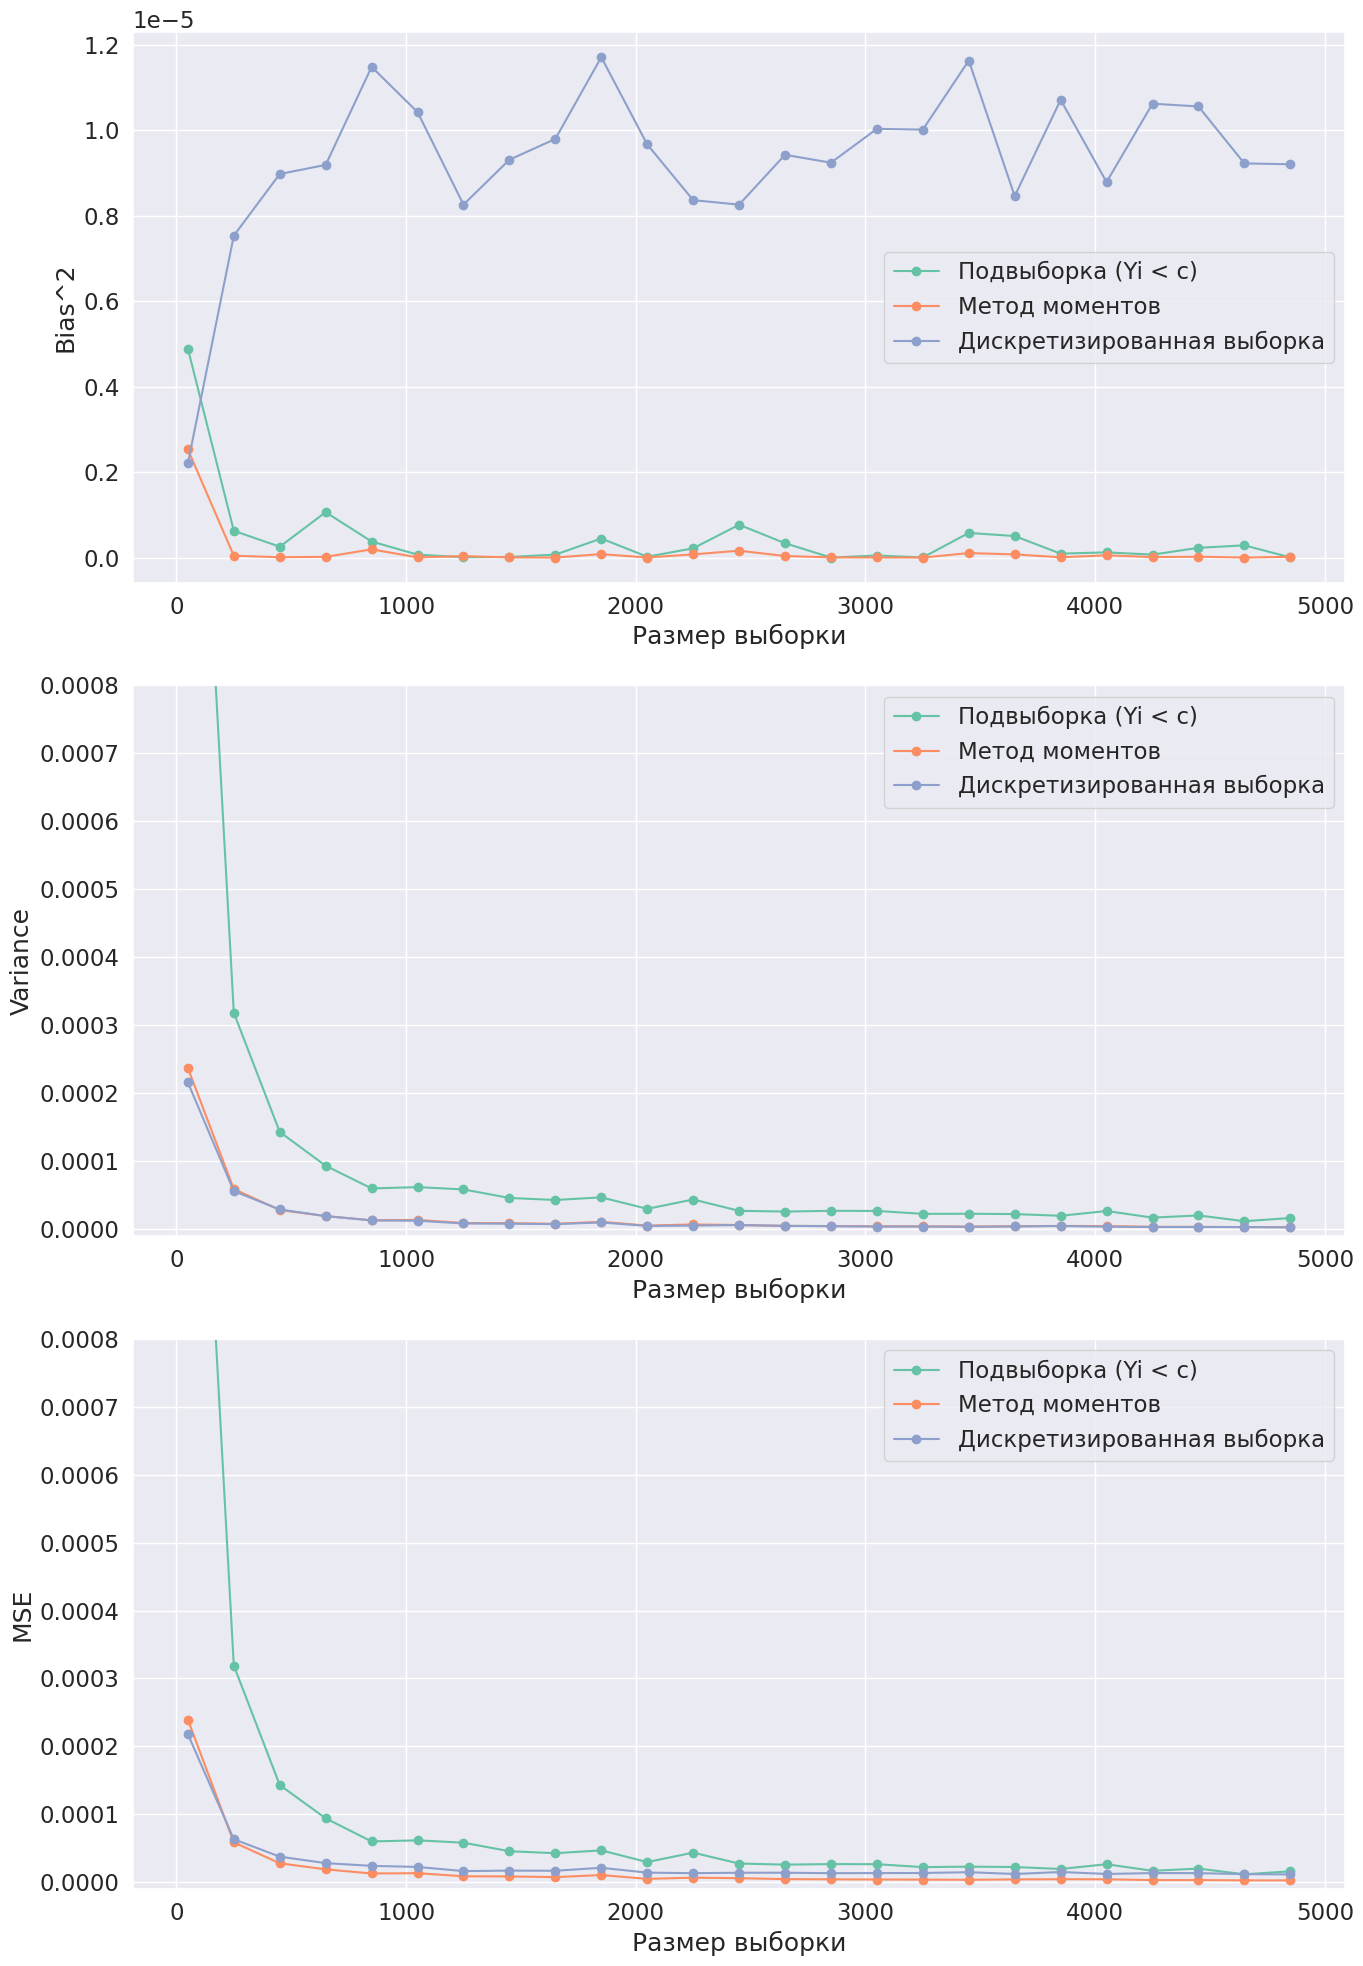

In [8]:
# Построение графиков для сравнения смещения, дисперсии и MSE
plt.figure(figsize=(14, 20))

# График смещения (Bias^2)
plt.subplot(3, 1, 1)
plt.plot(sizes, bias_squared_conditional, label='Подвыборка (Yi < c)', marker='o')
plt.plot(sizes, bias_squared_moments, label='Метод моментов', marker='o')
plt.plot(sizes, bias_squared_discrete, label='Дискретизированная выборка', marker='o')
plt.xlabel('Размер выборки')
plt.ylabel('Bias^2')
plt.legend()
plt.grid(True)

# График дисперсии (Variance)
plt.subplot(3, 1, 2)
plt.plot(sizes, variance_conditional, label='Подвыборка (Yi < c)', marker='o')
plt.plot(sizes, variance_moments, label='Метод моментов', marker='o')
plt.plot(sizes, variance_discrete, label='Дискретизированная выборка', marker='o')
plt.xlabel('Размер выборки')
plt.ylabel('Variance')
plt.ylim(-0.00001, 0.0008)
plt.legend()
plt.grid(True)

# Построение графиков для сравнения MSE
plt.subplot(3, 1, 3)
plt.plot(sizes, mse_conditional, label='Подвыборка (Yi < c)', marker='o')
plt.plot(sizes, mse_moments, label='Метод моментов', marker='o')
plt.plot(sizes, mse_discrete, label='Дискретизированная выборка', marker='o')
plt.xlabel('Размер выборки')
plt.ylabel('MSE')
plt.ylim(-0.00001, 0.0008)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Вывод:**
Из графика для смещения видно, что дискретезированная выборка сильно смещена вверх относительно остальных методов, так как не учитывает обрезание.
Дисперсия оценок уменьшается с увеличением размера выборки для всех методов.
Из графика MSE видно, что первый метод работает хуже всех на небольших выборках (< 1000), так как использует не всю выборку для получении оценки.
Однако результаты всех методов находятся в окрестности истинного значения параметра, что позволяет применять их с достаточной эффективностью.